# Feature Scaling & Learning Rate (Multivariable)

### Goals
In this lab, you will:
- Apply multivariable gradient descent  
- Examine how learning rate (α) affects convergence  
- Enhance performance using z-score feature scaling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2) # this just makes the output look nicer
from utils import *


**Problem Statement**  
In this lab, I’ll build a linear regression model to predict housing prices using four features: size (sqft), bedrooms, floors, and age. Unlike previous labs, size is measured in square feet rather than thousands. The dataset is larger, allowing you to predict prices for new cases, such as a 1200 sqft, 3-bedroom, 1-floor, 40-year-old house.


## Dataset Overview

### Housing Dataset
The `create_housing_dataset()` function generates synthetic housing data with 4 features:
- **Size (sqft)**: 800-3000 sqft (normally distributed around 1500)
- **Bedrooms**: 1-5 bedrooms (weighted toward 2-4)
- **Floors**: 1-3 floors (mostly 1-2)
- **Age**: 0-100 years (more newer homes)

**Price calculation**: Base price (~$150/sqft) + bedroom bonus + floor premium - age depreciation + market noise

### Why Feature Scaling is Needed
The features have very different scales:
- Size: 800-2240 (large numbers)
- Bedrooms: 1-5 (small numbers)
- Age: 0-93 (medium numbers)

Without scaling, gradient descent would be dominated by the largest-scale feature (size), making convergence slow and unstable.

In [2]:
# Create the housing dataset
x_train, y_train = create_housing_dataset(n_samples=100, random_seed=42)

# Print the dataset
print_housing_data(x_train, y_train, num_examples=10)

# Display basic statistics
print(f"\nDataset shape: {x_train.shape}")
print(f"Features: Size(sqft), Bedrooms, Floors, Age")
print(f"Target: Price (in thousands of dollars)")

Dataset contains 100 examples
--------------------------------------------------------------------------------
Size(sqft) | Bedrooms | Floors | Age | Price(1000s)
--------------------------------------------------------------------------------
     1698 |        3 |      2 |   8 |       315.1
     1444 |        2 |      1 |  28 |       217.7
     1759 |        2 |      1 |   0 |       271.2
     2109 |        3 |      1 |   2 |       364.7
     1406 |        4 |      1 |   0 |       266.2
     1406 |        3 |      2 |   0 |       247.7
     2131 |        3 |      1 |  38 |       328.5
     1806 |        4 |      1 |  24 |       313.9
     1312 |        3 |      2 |  12 |       199.4
     1717 |        5 |      1 |   2 |       264.3
... and 90 more examples
--------------------------------------------------------------------------------
Size range: 800 to 2240 sqft
Bedrooms range: 1 to 5
Floors range: 1 to 3
Age range: 0 to 93 years
Price range: $114.0k to $387.5k

Dataset shape: (100

In [3]:
# load the dataset
X_train, y_train = load_house_data()
X_features = ['size(sqft)','bedrooms','floors','age']

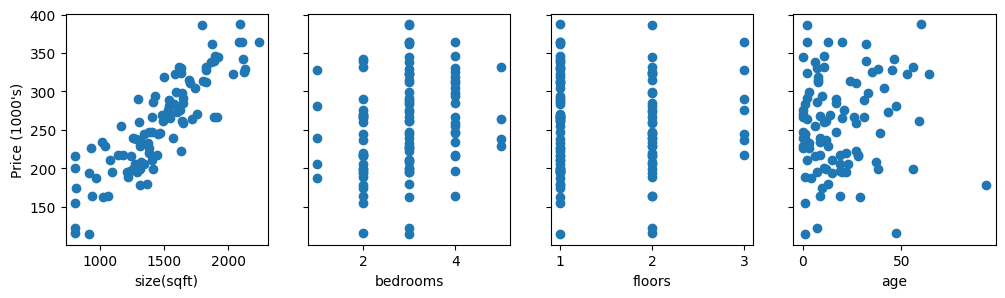

In [4]:
# Plot each feature against price
fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:, i], y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

Comparing each feature with price shows which factors most affect it. Larger homes cost more, while bedrooms and floors have little impact. Newer houses tend to be pricier.

<a name="toc_15456_5"></a>
## Gradient Descent with Multiple Variables

In this section, I use gradient descent for multiple variables:

$$
\begin{align*}
\text{repeat until convergence:} \; \lbrace \newline
&w_j := w_j - \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \quad (j = 0..n-1) \newline
&b := b - \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline
\rbrace
\end{align*}
$$

Here, *n* is the number of features, and parameters $w_j$ and $b$ are updated together.

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j} &= \frac{1}{m} \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_j^{(i)} \\
\frac{\partial J(\mathbf{w},b)}{\partial b} &= \frac{1}{m} \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align}
$$

* *m* is the number of training examples.  
* $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is my model’s prediction, and $y^{(i)}$ is the actual value.


## Learning Rate (α) Impact

The learning rate α controls how big steps gradient descent takes when updating parameters. It's shared across all features.

**Too large α**: Overshoots the minimum, may diverge

**Too small α**: Takes too long to converge

**Just right α**: Efficiently finds the minimum

Let's test different α values on our housing dataset to see the effect on convergence.

#### $\alpha$ = 9.9e-7


In [5]:
# Run gradient descent with high alpha (causing divergence)
_, _, hist = run_gradient_descent(X_train, y_train, 10, alpha = 9.9e-7)


Iteration | Cost      | w0       | w1       | w2       | w3       | b        | djdw0    | djdw1    | djdw2    | djdw3    | djdb
------------------------------------------------------------------------------------------------------------------------
        0 | 3.49565e+04 |  0.0e+00 |  0.0e+00 |  0.0e+00 |  0.0e+00 |  0.0e+00 | -4.0e+05 | -7.6e+02 | -3.9e+02 | -4.9e+03 | -2.6e+02
        1 | 5.36712e+04 |  3.9e-01 |  7.5e-04 |  3.8e-04 |  4.9e-03 |  2.5e-04 |  4.9e+05 |  9.3e+02 |  4.7e+02 |  6.4e+03 |  3.2e+02
        2 | 8.25522e+04 | -9.5e-02 | -1.6e-04 | -8.1e-05 | -1.5e-03 | -5.8e-05 | -6.1e+05 | -1.2e+03 | -5.9e+02 | -7.7e+03 | -4.0e+02
        3 | 1.27122e+05 |  5.1e-01 |  1.0e-03 |  5.1e-04 |  6.2e-03 |  3.3e-04 |  7.6e+05 |  1.4e+03 |  7.3e+02 |  9.9e+03 |  4.9e+02
        4 | 1.95904e+05 | -2.4e-01 | -4.2e-04 | -2.1e-04 | -3.6e-03 | -1.5e-04 | -9.4e+05 | -1.8e+03 | -9.1e+02 | -1.2e+04 | -6.1e+02
        5 | 3.02050e+05 |  6.9e-01 |  1.4e-03 |  6.9e-04 |  8.2e-03 |  4.6e-04 | 

Key Observations:
1. Alpha is TOO HIGH
The cost is exploding (increasing dramatically):
Started at 35,000
Ended at 1,710,000 (almost 50x increase!)
This is a classic sign of a learning rate that's too large.

𝛼
  = 9e-7
Let's try this now

In [8]:
#set alpha to 9e-7
_,_,hist = run_gradient_descent(X_train, y_train, 10, alpha = 9e-7)

Iteration | Cost      | w0       | w1       | w2       | w3       | b        | djdw0    | djdw1    | djdw2    | djdw3    | djdb
------------------------------------------------------------------------------------------------------------------------
        0 | 3.49565e+04 |  0.0e+00 |  0.0e+00 |  0.0e+00 |  0.0e+00 |  0.0e+00 | -4.0e+05 | -7.6e+02 | -3.9e+02 | -4.9e+03 | -2.6e+02
        1 | 3.76550e+04 |  3.6e-01 |  6.8e-04 |  3.5e-04 |  4.5e-03 |  2.3e-04 |  4.1e+05 |  7.7e+02 |  3.9e+02 |  5.4e+03 |  2.6e+02
        2 | 4.05648e+04 | -1.4e-02 | -9.9e-06 | -4.1e-06 | -4.0e-04 | -5.6e-06 | -4.3e+05 | -8.2e+02 | -4.2e+02 | -5.3e+03 | -2.8e+02
        3 | 4.37025e+04 |  3.7e-01 |  7.3e-04 |  3.7e-04 |  4.4e-03 |  2.4e-04 |  4.4e+05 |  8.3e+02 |  4.2e+02 |  5.8e+03 |  2.8e+02
        4 | 4.70860e+04 | -2.8e-02 | -2.2e-05 | -9.3e-06 | -8.2e-04 | -1.2e-05 | -4.6e+05 | -8.8e+02 | -4.5e+02 | -5.8e+03 | -3.0e+02
        5 | 5.07345e+04 |  3.8e-01 |  7.7e-04 |  3.9e-04 |  4.4e-03 |  2.6e-04 | 

𝛼
  = 1e-7
Let's try this

In [10]:
#set alpha to 1e-7
_,_,hist = run_gradient_descent(X_train, y_train, 10, alpha = 1e-7)

Iteration | Cost      | w0       | w1       | w2       | w3       | b        | djdw0    | djdw1    | djdw2    | djdw3    | djdb
------------------------------------------------------------------------------------------------------------------------
        0 | 3.49565e+04 |  0.0e+00 |  0.0e+00 |  0.0e+00 |  0.0e+00 |  0.0e+00 | -4.0e+05 | -7.6e+02 | -3.9e+02 | -4.9e+03 | -2.6e+02
        1 | 2.11182e+04 |  4.0e-02 |  7.6e-05 |  3.9e-05 |  4.9e-04 |  2.6e-05 | -3.1e+05 | -5.9e+02 | -3.0e+02 | -3.8e+03 | -2.0e+02
        2 | 1.28385e+04 |  7.0e-02 |  1.4e-04 |  6.9e-05 |  8.7e-04 |  4.6e-05 | -2.4e+05 | -4.6e+02 | -2.3e+02 | -2.9e+03 | -1.5e+02
        3 | 7.88466e+03 |  9.4e-02 |  1.8e-04 |  9.2e-05 |  1.2e-03 |  6.1e-05 | -1.8e+05 | -3.6e+02 | -1.8e+02 | -2.2e+03 | -1.2e+02
        4 | 4.92070e+03 |  1.1e-01 |  2.2e-04 |  1.1e-04 |  1.4e-03 |  7.3e-05 | -1.4e+05 | -2.8e+02 | -1.4e+02 | -1.7e+03 | -9.3e+01
        5 | 3.14731e+03 |  1.3e-01 |  2.4e-04 |  1.2e-04 |  1.6e-03 |  8.2e-05 | 

Key Observations:
1. Cost is Decreasing - Good Sign!
Started at 34,956 and decreased to 6,842
This shows the learning rate is not too large (unlike the previous exploding cost)
The algorithm is making progress toward the minimum
2. But Still Not Optimal

## Feature Scaling


Rescaling ensures that all features share a similar range.  
For more explanation, I can open the **details** section below. Otherwise, I’ll move on to implementing feature scaling.


The lectures covered three normalization methods:

- **Feature scaling:** Divide each feature by its maximum or use min–max scaling  
  $(x - \min)/( \max - \min)$ to map values between –1 and 1.  
- **Mean normalization:** $x_i = \dfrac{x_i - \mu_i}{\max - \min}$
- **Z-score normalization:** explored below.

### Z-score normalization
This method standardizes features to have a mean of 0 and a standard deviation of 1:

$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$  

where $j$ indexes each feature in $\mathbf{X}$, $\mu_j$ is its mean, and $\sigma_j$ its standard deviation.

$$
\begin{align}
\mu_j &= \frac{1}{m}\sum_{i=0}^{m-1}x^{(i)}_j \tag{5}\\
\sigma^2_j &= \frac{1}{m}\sum_{i=0}^{m-1}(x^{(i)}_j-\mu_j)^2 \tag{6}
\end{align}
$$

> **Implementation note:** I must save the mean and standard deviation used for training so that any new input is normalized using these same values before making predictions.


In [11]:
def zscore_normalize_features(X):
    """
    Normalizes features using z-score normalization (mean=0, std=1)
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): normalized input data
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature. axis=0 means compute the mean for each feature
    mu     = np.mean(X, axis=0)                 # mu with shape (n,)
    # Standard deviation. axis=0 means compute the standard deviation for each feature
    sigma  = np.std(X, axis=0)                  # sigma with shape (n,)
    # subtract mean and divide by standard deviation
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)
 
#check our work
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

In [13]:
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)
mu     = np.mean(X_train,axis=0)   
sigma  = np.std(X_train,axis=0) 
X_mean = (X_train - mu)
X_norm = (X_train - mu)/sigma 

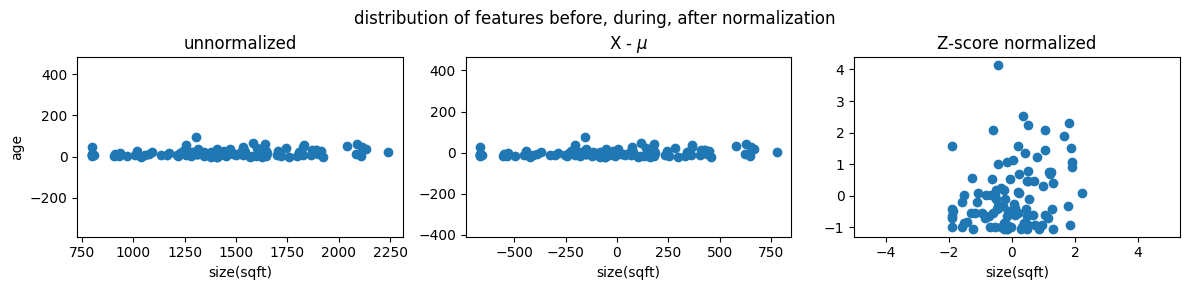

In [14]:
fig,ax=plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(X_train[:,0], X_train[:,3])
ax[0].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[0].set_title("unnormalized")
ax[0].axis('equal')

ax[1].scatter(X_mean[:,0], X_mean[:,3])
ax[1].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[1].set_title(r"X - $\mu$")
ax[1].axis('equal')

ax[2].scatter(X_norm[:,0], X_norm[:,3])
ax[2].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[2].set_title(r"Z-score normalized")
ax[2].axis('equal')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("distribution of features before, during, after normalization")
plt.show()

The plot compares two training features, **age** and **size (sqft)**, on the same scale.

- **Left (Unnormalized):** The variance of *size (sqft)* is much larger than *age*.  
- **Middle (Mean-centered):** After subtracting the mean, both features are centered around zero; *size (sqft)* shows this more clearly.  
- **Right (Standardized):** After dividing by the standard deviation, both features have similar scales, centered near zero.


In [15]:
# normalize the original features
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

X_mu = [1463.98    2.91    1.5    18.77], 
X_sigma = [348.27   0.92   0.62  17.99]
Peak to Peak range by column in Raw        X:[1440    4    2   93]
Peak to Peak range by column in Normalized X:[4.13 4.36 3.2  5.17]


Re-run the gradient descent algo. with normalized data. 

In [17]:
w_norm, b_norm, hist = run_gradient_descent(X_norm, y_train, 1000, 1.0e-1, )

Iteration | Cost      | w0       | w1       | w2       | w3       | b        | djdw0    | djdw1    | djdw2    | djdw3    | djdb
------------------------------------------------------------------------------------------------------------------------
        0 | 3.49565e+04 |  0.0e+00 |  0.0e+00 |  0.0e+00 |  0.0e+00 |  0.0e+00 | -5.3e+01 | -1.4e+01 | -3.8e-01 | -6.6e+00 | -2.6e+02
        1 | 2.83850e+04 |  5.3e+00 |  1.4e+00 |  3.8e-02 |  6.6e-01 |  2.6e+01 | -4.7e+01 | -1.2e+01 | -9.6e-01 | -4.8e+00 | -2.3e+02
        2 | 2.30681e+04 |  1.0e+01 |  2.5e+00 |  1.3e-01 |  1.1e+00 |  4.9e+01 | -4.2e+01 | -9.7e+00 | -1.4e+00 | -3.3e+00 | -2.1e+02
        3 | 1.87656e+04 |  1.4e+01 |  3.5e+00 |  2.7e-01 |  1.5e+00 |  7.0e+01 | -3.8e+01 | -8.2e+00 | -1.7e+00 | -2.0e+00 | -1.9e+02
        4 | 1.52833e+04 |  1.8e+01 |  4.3e+00 |  4.4e-01 |  1.7e+00 |  8.8e+01 | -3.4e+01 | -6.8e+00 | -1.9e+00 | -1.0e+00 | -1.7e+02
        5 | 1.24645e+04 |  2.1e+01 |  5.0e+00 |  6.4e-01 |  1.8e+00 |  1.1e+02 | 

Scaled features yield accurate results much faster. By the end of training, parameter gradients are nearly zero. A learning rate of 0.1 works well for normalized data. I will now plot the predictions versus target values, using normalized features for prediction but original values for visualization.


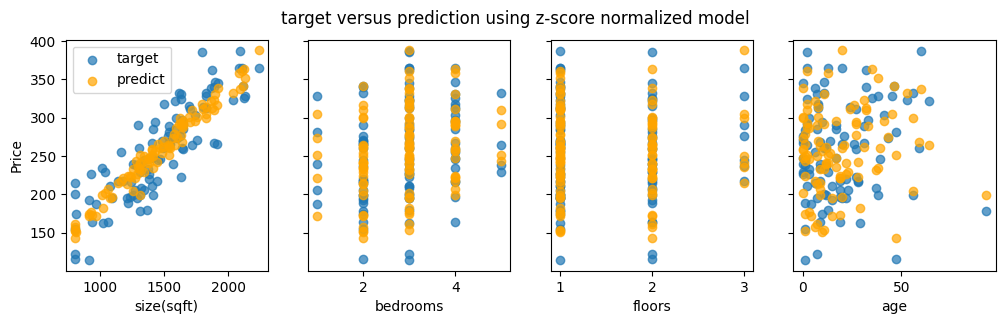

In [19]:
# Make predictions using the normalized model
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

# Plot predictions vs actual for each feature
fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:, i], y_train, label='target', alpha=0.7)
    ax[i].scatter(X_train[:, i], yp, color='orange', label='predict', alpha=0.7)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price")
ax[0].legend()
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

## Prediction Visualization

**Blue points (target)**: Actual house prices from the dataset

**Orange points (predict)**: Model predictions using the trained linear regression

**What to look for:**
- **Good model**: Orange points closely follow blue points
- **Poor model**: Orange points are scattered far from blue points

**Each subplot shows:**
- How well the model captures the relationship between each feature and price
- Whether predictions match the actual data patterns

The results look good. Key notes:

- With multiple features, I cannot show all results in one plot.  
- The plot used normalized features, so any new predictions must also be normalized.


### Prediction
The goal of building this model is to predict housing prices not in the dataset. I will predict the price of a 1,200 sq ft house with 3 bedrooms, 1 floor, and 40 years of age. The input must be normalized using the mean and standard deviation from the training data.


In [20]:
# First, normalize out example.
x_house = np.array([1200, 3, 1, 40])
x_house_norm = (x_house - X_mu) / X_sigma
print(x_house_norm)
x_house_predict = np.dot(x_house_norm, w_norm) + b_norm
print(f" predicted price of a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old = ${x_house_predict*1000:0.0f}")

[-0.76  0.1  -0.8   1.18]
 predicted price of a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old = $205891
